In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os

In [ ]:
# Load saved models and results
bandit_difficulty = 'restless'
PLAYGROUND_DIR = f"~/logs/EI_RLDM/bandit/{bandit_difficulty}"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
num_episodes = 800  # Adjust based on training Episodes
batch_size = 256
n_seeds = 20
grad_clip_list = [1]
rad_list = [1.]
lr_list = [6e-4, 8e-4, 1e-3, 1.5e-3, 2e-3]
lr_list = [round(learning_rate, 5) for learning_rate in lr_list]
seeds = [i for i in range(n_seeds)]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(_, _, _, rad, ei_ratio) = para_comb[0]

lr_gc_list = list(itertools.product(lr_list, grad_clip_list))
# Initialize dictionaries to store losses
models = {i: {"rnn": {}, 
            #   "colei": {}, 
              "danns": {}} for i, _ in enumerate(lr_gc_list)}

n_hidden = 48

In [ ]:
para_comb_next = {"rnn": [], "danns": []}
for i, (lr, gc)  in enumerate(lr_gc_list):
    for model_type in models[i].keys():
        models[i][model_type] = {k: np.zeros((n_seeds, num_episodes)) for k in ["regret", "train_loss"]}

        for seed in seeds:
            if model_type == "colei":
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_adam.npz"
            elif model_type == 'rnn':
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
            else:
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
            
            try:
                if os.path.exists(results_path):
                    data = np.load(results_path)
                    models[i][model_type]["train_loss"][seed, :] = data["train_loss"][:num_episodes]
                    models[i][model_type]["regret"][seed, :] = data["regret"][:num_episodes]
                else:
                    print(f"Warning: Missing file {results_path}")
                    para_comb_next.append((seed, lr, gc, 1., ei_ratio, False))
            except Exception as e:
                    print(e, results_path)
                    para_comb_next[model_type].append((seed, lr, gc, 1., ei_ratio, False))

In [23]:
def exp_avg_convolve(arr, alpha):
    kernel = (1 - alpha) ** np.arange(len(arr))
    kernel /= kernel.sum()
    return np.convolve(arr, kernel, mode='full')[:len(arr)]

In [24]:

# Compute mean and standard deviation across seeds
train_loss_mean =  {i: {model: np.mean(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
train_loss_std = {i: {model: np.std(models[i][model]["train_loss"], axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_mean = {i: {model: np.mean(np.array([exp_avg_convolve(models[i][model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_std = {i: {model: np.std(np.array([exp_avg_convolve(models[i][model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_mean2 = {i: {model: np.mean(np.trapz(models[i][model]["regret"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
regret_std2 = {i: {model: np.std(np.trapz(models[i][model]["regret"], axis=-1), axis=0) for model in models[i]} for i, (lr, gc) in enumerate(lr_gc_list)}


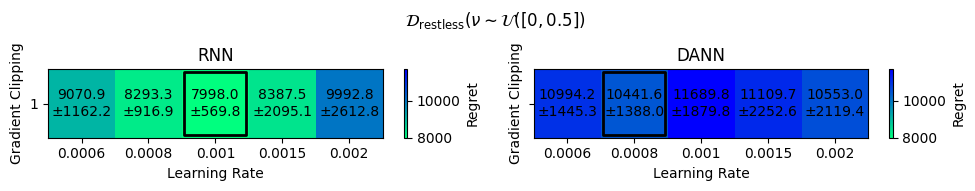

In [26]:
# Plot results
labels = {"rnn": "RNN", 
        #   "colei": "ColEI", 
          "danns": "DANN"}
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '-', '-','-','-','-','-']#,'--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(1, 2, figsize=(10, 2), sharey='row', sharex=False, squeeze=False)

all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = regret_mean2
loss_std = regret_std2
linestyle = linestyles[0]
mins = []
maxs = []
heatmaps = {}
scores = {}
# for i, (lr, linestyle) in enumerate(zip(lr_list, linestyles)):
for j, model_type in enumerate(labels.keys()):

    # Convert lr_gc_list and loss_mean into structured arrays
    lr_values = sorted(set(lr for lr, gc in lr_gc_list))  # Unique sorted learning rates
    gc_values = sorted(set(gc for lr, gc in lr_gc_list))  # Unique sorted gradient clipping values

    # Create a 2D array for accuracy values
    heatmap_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Initialize with NaNs
    # Create 2D arrays for accuracy and std values
    std_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Standard deviation values
    score_matrix = np.full((len(gc_values), len(lr_values)), np.nan)  # Mean - std values

    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list)])
    # Fill matrices
    for i, (lr, gc) in enumerate(lr_gc_list):
        row = gc_values.index(gc)
        col = lr_values.index(lr)
        mean_val = loss_mean[i][model_type]  # Accuracy
        std_val = loss_std[i][model_type]  # Standard deviation
        heatmap_matrix[row, col] = mean_val
        std_matrix[row, col] = std_val
        score_matrix[row, col] = mean_val + std_val  # Mean - std score
    
    # Define common colormap range
    vmin = min(np.nanmin(heatmap_matrix), np.nanmin(std_matrix), np.nanmin(score_matrix))
    vmax = max(np.nanmax(heatmap_matrix), np.nanmax(std_matrix), np.nanmax(score_matrix))
    mins.append(np.nanmin(heatmap_matrix))
    maxs.append(np.nanmax(heatmap_matrix)) 
    heatmaps[model_type] = heatmap_matrix
    scores[model_type] = score_matrix
    # Set tick labels
    ax[j].set_xticks(np.arange(len(lr_values)))
    ax[j].set_yticks(np.arange(len(gc_values)))
    ax[j].set_xticklabels(lr_values)
    ax[j].set_yticklabels(gc_values)

    # Labels
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_ylabel("Gradient Clipping")

    # Annotate cells with mean ± std
    for i in range(len(gc_values)):
        for k in range(len(lr_values)):
            value = heatmap_matrix[i, k]
            std = std_matrix[i, k]
            if not np.isnan(value):
                ax[j].text(k, i, f"{value:.1f}\n±{std:.1f}", ha="center", va="center", 
                        color="white" if value < np.max(heatmap_matrix) / 2 else "black")

vmin = np.min(mins)
vmax = np.max(maxs)
for j, model_type in enumerate(labels.keys()):
    cax = ax[j].imshow(heatmaps[model_type], cmap=plt.cm.winter.reversed(), aspect="auto", vmin=vmin, vmax=vmax)

    # Find best (mean - std) location
    best_idx = np.unravel_index(np.argmin(scores[model_type]), scores[model_type].shape)

    # Add colorbar
    cbar = plt.colorbar(cax, ax=ax[j])
    cbar.set_label("Regret")
    ax[j].set_title(labels[model_type])
    # Highlight best (mean - std) value
    ax[j].scatter(best_idx[1], best_idx[0], marker="s", s=2000, facecolors='none', edgecolors='k', linewidths=2)
fig.suptitle(r"$\mathcal{D}_{\mathrm{restless}} (\nu \sim \mathcal{U}([0,0.5])$", y=0.93)
plt.tight_layout()
plt.show()

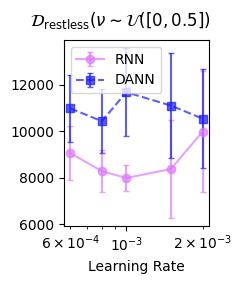

In [ ]:
# Plot results
labels = {"rnn": "RNN", 
        #   "colei": "ColEI", 
          "danns": "DANN"}
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
fig, axes = plt.subplots(1, 1, figsize=(2.5, 3), sharey=True, sharex=True, squeeze=False)
colors =  ["#dd7aff", "#1a1aff", "#17b9ad" ]
all_loss_values = {model_type: [] for model_type in labels.keys()}

ax = axes[0, :]
loss_mean = regret_mean2
loss_std = regret_std2
markers = ["o", "s", "v", "x"]
mins = []
maxs = []
heatmaps = {}
scores = {}

j = 0
gc_p = 1
for k, model_type in enumerate(labels.keys()):
    

    # Extract loss values for gradient clipping = 1
    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    r_values = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    # Plot the U-curve
    # ax[j].plot(lr_values, loss_values, label=f"{labels[model_type]}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
    ax[j].errorbar(lr_values, loss_values, yerr=std_values, label=f"{labels[model_type]}", color=colors[k], marker=markers[k], linestyle=linestyles[k],capsize=2, alpha=0.7, zorder=3)
    # ax[j].set_title("Gradient clip " + f"(gc:{gc_p})")
    ax[j].set_xlabel("Learning Rate")
    ax[j].set_xticks(lr_values)
    # ax[j].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x}"))
    # ax[j].set_ylabel("Regret")
    ax[j].legend()
    ax[j].set_xscale("log")  # Assuming learning rates are logarithmically spaced
fig.suptitle(r"$\mathcal{D}_{\mathrm{restless}} (\nu \sim \mathcal{U}([0,0.5])$", y=0.93)
plt.tight_layout()
plt.show()

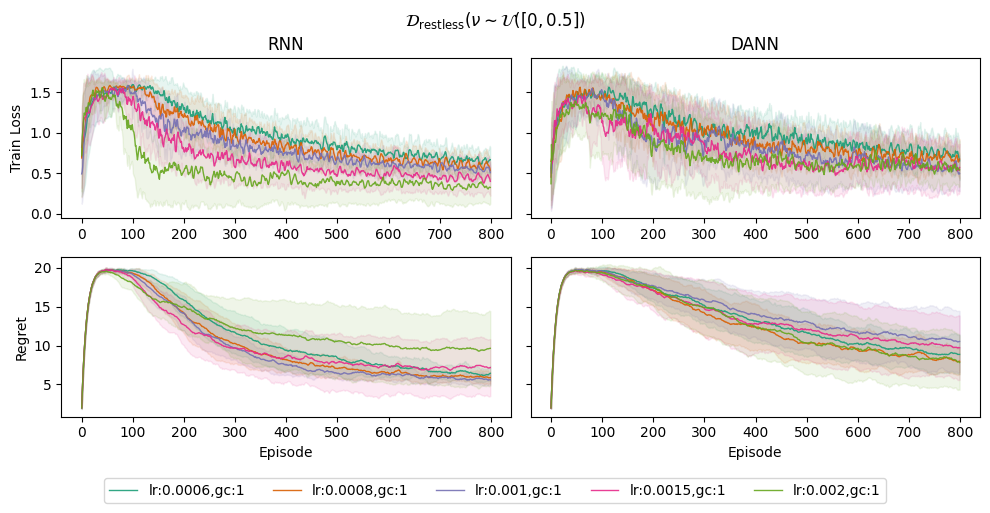

In [30]:

# Plot results
labels = {"rnn": "RNN", 
        #   "colei": "ColEI", 
          "danns": "DANN"}
COLORS = plt.get_cmap('Dark2').colors
linestyles = ['-', '-', '-','-','-','-']#,'--', ':', "-."]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]

fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharey='row', sharex=False)

# Training Loss

### Helper Function to Plot with Dynamic Y-Limits ###
def plot_metric(ax, loss_mean, loss_std, title, y_label, plot_x_label=True):
    all_loss_values = {model_type: [] for model_type in labels.keys()}

    for i, ((lr, gc), linestyle) in enumerate(zip(lr_gc_list, linestyles)):
        for j, model_type in enumerate(labels.keys()):
            loss_values = loss_mean[i][model_type]
            std_values = loss_std[i][model_type]

            # Collect values for dynamic y-limit computation
            all_loss_values[model_type].extend(loss_values - std_values)
            all_loss_values[model_type].extend(loss_values + std_values)

            # Plot mean and std range
            ax[j].plot(loss_values, label=f"lr:{lr},gc:{gc}", color=colors[i], linestyle=linestyles[i],lw=1, alpha=0.9, zorder=2)
            ax[j].fill_between(range(num_episodes), loss_values - std_values, loss_values + std_values, color=colors[i],  alpha=0.1)

    for j, model_type in enumerate(labels.keys()):
        if plot_x_label:
            ax[j].set_xlabel("Episode")
    ax[0].set_ylabel(f"{y_label}")
        # ax[j].legend()
       

        # # Apply dynamic y-limits (ignore NaN, remove extreme outliers)
        # all_loss_values[model_type] = np.nan_to_num(all_loss_values[model_type], nan=0)
        # y_min, y_max = np.percentile(all_loss_values[model_type], [1, 99])
        # ax[j].set_ylim(y_min, y_max)

### **Train Loss Plot (Row 1, Col 0)**
for j, model_type in enumerate(labels.keys()):
    axes[0, j].set_title(f"{labels[model_type]}")

plot_metric(axes[0, :], train_loss_mean, train_loss_std, "Train Loss", "Train Loss", plot_x_label=False)

### **Test Loss Plot (Row 1, Col 1)**
plot_metric(axes[1, :], regret_mean, regret_std, "Regret", "Regret")


handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05))
fig.suptitle(r"$\mathcal{D}_{\mathrm{restless}} (\nu \sim \mathcal{U}([0,0.5])$", y=0.95)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()